In [ ]:
from collections import OrderedDict

import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.linear_model import LinearRegression
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt

from typing import Callable
import dataclasses

"""
if using scheduling or early stop, validation goes after training

real variation:

  model depth
  activation
  error for regression
  lr for classification

  learning rate graph
  differences bar chart
  bar chart chape


"""

'''
training data list
training labels list
vary sort order
vary data scaling
must be in tensor form
'''


@dataclasses.dataclass
class T_Data:
  # t_data = T_Data(train_set, train_label, valid_set, valid_label)
  def __init__(self, data: list, labels: list, vdata: list, vlabels: list):
    self.classes = int(max(labels))
    temp_labels = labels.copy()
    temp_data = data.copy()
    temp_vdata = vdata.copy()
    temp_vlabels = vlabels.copy()
    self.data, self.labels, self.vdata, self.vlabels = [], [], [], []

    for i in range(len(temp_data)):
      self.data.append(torch.autograd.Variable(torch.FloatTensor([temp_data[i]]), requires_grad=True).squeeze())
      self.labels.append(self.one_hot_encode(temp_labels[i]))

    for i in range(len(vdata)):
      self.vdata.append(torch.autograd.Variable(torch.FloatTensor([temp_vdata[i]]), requires_grad=True).squeeze())
      self.vlabels.append(self.one_hot_encode(temp_vlabels[i]))

  def one_hot_encode(self, one_based_index):
    one_hot_tensor = torch.zeros(self.classes)
    one_hot_tensor[int(one_based_index) - 1] = 1
    return one_hot_tensor


  def change_device(self, device):
    self.data = [d.to(device) for d in self.data]
    self.labels = [l.to(device) for l in self.labels]
    self.vdata = [vd.to(device) for vd in self.vdata]
    self.vlabels = [vl.to(device) for vl in self.vlabels]


@dataclasses.dataclass
class R_Data:
  def __init__(self, data, labels):
    temp_data = data.copy()
    self.data, self.actual, self.predictions = [], [], []
    for i in range(len(data)):
      self.data.append(torch.autograd.Variable(torch.FloatTensor([temp_data[i]]), requires_grad=True))
      self.actual.append(labels[i])

  def change_device(self, device):
    self.data = [d.to(device) for d in self.data]

  def de_tensor(self):
    scalars = []
    for i in self.predictions:
      scalars.append(i.item())
    self.predictions = scalars

  def de_tensor2(self):
    self.predictions = [i.cpu() for i in self.predictions]

class EarlyStop:
    def __init__(self, patience=7, min_delta=-1):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = val_loss
            self.counter = 0


class MLP(nn.Module):
  def __init__(self, d: dict):
    super(MLP, self).__init__()
    self.new = d['new']
    self.t = d['type']
    self.n_epochs = d['n_epochs']
    self.s = d['s']
    self.l = d['l']
    self.m = d['m']
    self.inputs = d['inputs']
    self.outputs = d['outputs']
    self.ef = d['ef']
    self.af = d['af']
    self.lr = d['lr']
    self.variation =  d['variation']
    self.early_stop = d['es']
    self.ES = EarlyStop(patience=self.n_epochs/10)
    self.loss_tracker = []  # keeps track of valid set
    self.accuracy_tracker = []
    l = self.get_m()
    af = self.get_af()
    layer_dict = OrderedDict()
    for i, w in enumerate(l):
      if len(w) < 3:
        layer_dict[f'l{i}'] = nn.Linear(w[0], w[1])
      if i + 1 < len(l):
        layer_dict[f'a{i}'] = af()
      elif self.t == "classifier":
        layer_dict[f'a{i}'] = nn.Softmax()
    self.layers = nn.Sequential(layer_dict)
    if not self.new:
      self.mlp_import(d['m'])
    func, kwargs = self.get_l()
    self.optimizer = func(self.parameters(), **kwargs)
    self.error_f = self.get_ef()()
    if d['s'] != 'none':
      func, kwargs = self.get_s()
      self.scheduler = func(self.optimizer, **kwargs)
    else:
      self.scheduler = None

  def get_ef(self):
    match(self.ef):
      case 'mse':
        return nn.MSELoss
      case 'ce':
        return nn.CrossEntropyLoss
      case 'mae':
        return nn.L1Loss
      case 'hl':
        return nn.HuberLoss
      case 'bce':
        return nn.BCEWithLogitsLoss
      case _:
        raise ValueError(f"Error function mismatch - {self.ef}")

  def get_af(self):
    match(self.af):
      case "relu":
        return nn.ReLU
      case "sigmoid":
        return nn.Sigmoid
      case "tanh":
        return nn.Tanh
      case _:
        raise ValueError(f"Activation function mismatch - {self.af}")

  def get_m(self):
    match(self.m):
      case '10x10':
        return [(self.inputs, 10), (10, 10), (10, 10), (10, 10), (10, 10),
                (10, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, self.outputs)]
      case '5x20':
        return [(self.inputs, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5),
                (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5), (5, 5),
                (5, 5), (5, 5), (5, 5), (5, 5), (5, 1)]
      case '20x5':
        return [(self.inputs, 20), (20, 20), (20, 20), (20, 20), (20, 20), (20, 1)]
      case '50x2':
        return [(self.inputs, 50), (50, 50), (50, 1)]
      case '10x1':
        return [(self.inputs, 10), (10, self.outputs)]
      case '10x2':
        return [(self.inputs, 10), (10, 10), (10, self.outputs)]
      case '10x3':
        return [(self.inputs, 10), (10, 10), (10, 10), (10, self.outputs)]
      case '10xreduce':
        return [(self.inputs, 10), (10, 8), (8, 6), (6, 4), (4, 2), (2, 1)]
      case '8x1':
        return [(self.inputs, 8), (8, self.outputs)]
      case '4x1':
        return [(self.inputs, 4), (4, self.outputs)]
      case '2x1':
        return [(self.inputs, 2), (2, self.outputs)]
      case '8x5':
        return [(self.inputs, 8), (8, 8), (8, 8),(8, 8),(8, 8), (8, 1)]
      case '65x2':
        return [(self.inputs, 65), (65, 65), (65, 1)]
      case _:
        raise ValueError(f"Model mismatch - {self.m}")

  def get_l(self):
    match(self.l):
      case 'sgd':
        return (optim.SGD, {'lr':self.lr, 'momentum':0.4})
      case 'adam':
        return (optim.Adam, {'lr':self.lr})
      case 'ada':
        return (optim.Adagrad, {'lr':self.lr})
      case _:
        raise ValueError(f"Learning function mismatch - {self.l}")

  def get_s(self):
    match(self.s):
      case 'const':
        return (optim.lr_scheduler.StepLR,
         {'step_size':self.n_epochs/5, 'gamma':0.1})
      case 'plat':
        return (optim.lr_scheduler.ReduceLROnPlateau,
                {'factor':0.1, 'patience':self.n_epochs/20, 'mode':'min',
                 'threshold':1,'threshold_mode': 'abs'})
      case _:
        raise ValueError(f"Schedule function mismatch - {self.s}")

  def forward(self, x):
    y = self.layers(x)
    return y

  def mlp_train(self, t_data: T_Data):
    self.train()
    for epoch in range(self.n_epochs):
      self.eval()
      val_loss = 0
      correct = 0
      total = 0
      with torch.no_grad():
        for i in zip(t_data.vdata, t_data.vlabels):
          vdata, vlabel = i
          output = self.forward(vdata)
          vloss = self.error_f(output, vlabel)
          val_loss += vloss.item()
          total += 1
          if torch.argmax(output) + 1 == torch.argmax(vlabel) + 1:
            correct += 1
        val_loss /= len(t_data.vdata)
        self.loss_tracker.append(val_loss)
        self.accuracy_tracker.append(correct / total)
      self.train()
      for i in range(len(t_data.data)):
        train_data = t_data.data[i]
        label = t_data.labels[i]
        m_out = self.forward(train_data)
        loss = self.error_f(m_out, label)
        self.optimizer.zero_grad()
        '''print(f"p - {m_out} l - {label}"); print(f"tdata - {train_data} label - {label}")'''
        loss.backward()
        self.optimizer.step()
      if self.early_stop and self.ES(val_loss):
        break
      elif self.s == 'none':
        pass
      elif self.s == 'plat':
        self.scheduler.step(val_loss)
      else:
        self.scheduler.step()

  def mlp_run(self, r_data: R_Data):
    self.eval()
    with torch.no_grad():
      for i in range(len(r_data.data)):
        data_point = r_data.data[i]
        output = self.forward(data_point)
        r_data.predictions.append(torch.argmax(output) + 1)
        #print(f"prediction: {prediction} real - {r_data.actual[i]}")
        #print(f"Test val: {t} - output {net(t_var)} - actual {t * 3}")

  def mlp_export(self, id):
    torch.save(self.state_dict(), id)

  def mlp_import(self, id):
    self.load_state_dict(torch.load(id))

  @staticmethod
  def create_dict():
    return {
      'new': True,
      'es': False,
      'inputs': 8,
      'n_epochs': 100,  # const
      'm': '10x10',
      's': 'const',
      'l': 'sgd',
      'ef': 'mse',
      'af': 'sigmoid',
      'lr': 0.0001,
      'type': "regression",
      'variation': 'none'
    }

  def print_info(self):
    print(f"Epochs - {self.n_epochs}")
    print(f"Optim - {self.l}")
    print(f"Model - {self.m}")
    print(f"Error - {self.ef}")
    print(f"Activation - {self.af}")
    print(f"Base learn - {self.lr}")
    print(f"Scheduler - {self.s}")
    print(self.state_dict())

  @staticmethod
  def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU (CUDA)")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import parse_version

''' printing services '''

def multi_plot_suite(a, t1, t2, t3, n_epochs, text):

  epochs = np.arange(n_epochs)
  plt.plot(epochs, t1['l'], marker='o', linestyle='-', color='b', label=t1['variation'])
  plt.plot(epochs, t2['l'], marker='o', linestyle='-', color='r', label=t2['variation'])
  plt.plot(epochs, t3['l'], marker='o', linestyle='-', color='g', label=t3['variation'])
  plt.title(f'Loss Decay Over Epochs - {text}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.plot(epochs, t1['a'], marker='o', linestyle='-', color='b', label=t1['variation'])
  plt.plot(epochs, t2['a'], marker='o', linestyle='-', color='r', label=t2['variation'])
  plt.plot(epochs, t3['a'], marker='o', linestyle='-', color='g', label=t3['variation'])
  plt.title(f'Accuracy Over Epochs - {text}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  classes = list(a.keys())
  values_a = [a[class_] for class_ in classes]
  values_t1 = [t1[class_] for class_ in classes]
  values_t2 = [t2[class_] for class_ in classes]
  values_t3 = [t3[class_] for class_ in classes]

  # Number of classes
  n_classes = len(classes)

  # Positions of the bar groups
  barWidth = 0.2
  r1 = np.arange(n_classes)
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]

  # Creating the bar plots
  plt.bar(r1, values_a, color='blue', width=barWidth, edgecolor='grey', label='actual')
  plt.bar(r2, values_t1, color='red', width=barWidth, edgecolor='grey', label=t1['variation'])
  plt.bar(r3, values_t2, color='green', width=barWidth, edgecolor='grey', label=t2['variation'])
  plt.bar(r4, values_t3, color='orange', width=barWidth, edgecolor='grey', label=t3['variation'])

  # Adding labels
  plt.xlabel('Class', fontweight='bold')
  plt.ylabel('Counts')
  plt.xticks([r + barWidth for r in range(n_classes)], classes)
  plt.title(f'Classification : {text}')

  # Create legend & Show graphic
  plt.legend()
  plt.show()

In [ ]:
X = []
Y = []
with open("wheat_data.txt", "r") as file:
  for line in file:
    tokens = line.strip().split("\t")
    features = [float(token) for token in tokens[:-1]]
    target = tokens[-1]
    X.append(features)
    Y.append(target)

X = np.array(X)
Y = np.array(Y)
classes = int(max(Y))
feature_len = int(len(X[0]))

#print(X)
#print(Y)

mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std



In [ ]:
import os
import pickle
import random

data_set = 'set3_75'
train_set, train_label, test_set, test_label = [], [], [], []

if os.path.exists(data_set):
  print("yes")
  with open(data_set, 'rb') as file:
    train_set, train_label, test_set, test_label = pickle.load(file)
else:
  index_list = list(range(len(X)))
  random.shuffle(index_list)
  set1, set2 = [], []
  for i, j in enumerate(index_list, start=1):
    if i % 4 != 0:
      set1.append(j)
    else:
      set2.append(j)
  for i in set1:
    train_set.append(X[i])
    train_label.append(Y[i])
  for i in set2:
    test_set.append(X[i])
    test_label.append(Y[i])
  with open(data_set, 'wb') as file:
    pickle.dump((train_set, train_label, test_set, test_label),
                file)

print(f"l train s - {len(train_set)} train_l - {len(train_label)} test s - {len(test_set)}, test l - {len(test_label)}")




l train s - 158 train_l - 158 test s - 52, test l - 52


In [ ]:
t_data = T_Data(train_set, train_label, test_set, test_label)
r_data = R_Data(test_set, test_label)

<ipython-input-1-f26c274c9eb2>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  self.data.append(torch.autograd.Variable(torch.FloatTensor([temp_data[i]]), requires_grad=True).squeeze())


In [ ]:
''' create model '''

'''print(f"l train s - {len(t_data.data)} train_l - {len(t_data.labels)} \
test s - {len(t_data.vdata)}, test l - {len(t_data.vlabels)}")'''

d = MLP.create_dict()
d['m'] = '2x1'
d['inputs'] = feature_len
d['outputs'] = classes
d['es'] = True

net = MLP(d)

net.mlp_export(d['m'])

In [ ]:
''' run model '''

"""Beware exploding/disappearing gradient issues"""

t_data = T_Data(train_set, train_label, test_set, test_label)
r_data = R_Data(test_set, test_label)

d = MLP.create_dict()
d['n_epochs'] = 5
d['m'] = '2x1'
d['inputs'] = feature_len
d['outputs'] = classes
d['new'] = False
d['l'] = 'adam'
d['s'] = 'none'
d['es'] = False
d['af'] = 'tanh'
d['ef'] = 'bce'
d['type'] = 'classifier'
d['lr'] = 0.01
d['variation'] = 'tanh'

'''d = MLP.create_dict()
d['n_epochs'] = 25
d['m'] = '10x2'
d['inputs'] = len(t_data.data[0])
d['new'] = False
d['l'] = 'adam'
d['s'] = 'none'
d['es'] = False
d['af'] = 'sigmoid'
d['ef'] = 'mse'
d['lr'] = 0.01
'''
device = MLP.get_device()

net = MLP(d)
net.to(device)

t_data.change_device(device)
r_data.change_device(device)

net.print_info()

net.mlp_train(t_data)
net.mlp_run(r_data)


Using CPU
Epochs - 5
Optim - adam
Model - 2x1
Error - bce
Activation - tanh
Base learn - 0.01
Scheduler - none
OrderedDict([('layers.l0.weight', tensor([[ 0.0027,  0.1734, -0.1350,  0.1408,  0.2792,  0.1748,  0.3153],
        [-0.0274, -0.0253, -0.0884, -0.2889,  0.0847, -0.1246, -0.0947]])), ('layers.l0.bias', tensor([-0.2976,  0.2487])), ('layers.l1.weight', tensor([[ 0.6973, -0.5732],
        [ 0.6347, -0.5016],
        [ 0.3445,  0.3687]])), ('layers.l1.bias', tensor([-0.4726, -0.2634, -0.0838]))])


In [ ]:
r_data.change_device('cpu')
r_data.de_tensor()

In [ ]:
''' print results '''

for j, i in enumerate(zip(r_data.predictions, r_data.actual)):
  print(f"I: {j} P: {i[0]} A: {i[1]}" )

'''plot_suite(r_data.predictions, r_data.actual, net, "ReLU")

net.state_dict()'''
''' print state info '''
''' print data set '''

In [ ]:
net.mlp_export(f"{d['m']} high score model2")

In [ ]:
actual = r_data.actual.copy()
n_epochs = net.n_epochs

a = {}
one = 0
two = 0
three = 0

for i in actual:
  match(int(i)):
    case 1:
      one += 1
    case 2:
      two += 1
    case 3:
      three += 1

a['one'] = one
a['two'] = two
a['three'] = three

In [ ]:
t1 = {}
p = r_data.predictions.copy()

one = 0
two = 0
three = 0

for i in p:
  match(i):
    case 1:
      one += 1
    case 2:
      two += 1
    case 3:
      three += 1

t1['one'] = one
t1['two'] = two
t1['three'] = three
t1['l'] = net.loss_tracker.copy()
t1['a'] = net.accuracy_tracker.copy()
t1['variation'] = net.variation

In [ ]:
t2 = {}

p = r_data.predictions.copy()

one = 0
two = 0
three = 0

for i in p:
  match(i):
    case 1:
      one += 1
    case 2:
      two += 1
    case 3:
      three += 1

t2['one'] = one
t2['two'] = two
t2['three'] = three
t2['l'] = net.loss_tracker.copy()
t2['a'] = net.accuracy_tracker.copy()
t2['variation'] = net.variation

In [ ]:
t3 = {}

p = r_data.predictions.copy()

one = 0
two = 0
three = 0

for i in p:
  match(i):
    case 1:
      one += 1
    case 2:
      two += 1
    case 3:
      three += 1

t3['one'] = one
t3['two'] = two
t3['three'] = three

t3['l'] = net.loss_tracker.copy()
t3['a'] = net.accuracy_tracker.copy()
t3['variation'] = net.variation

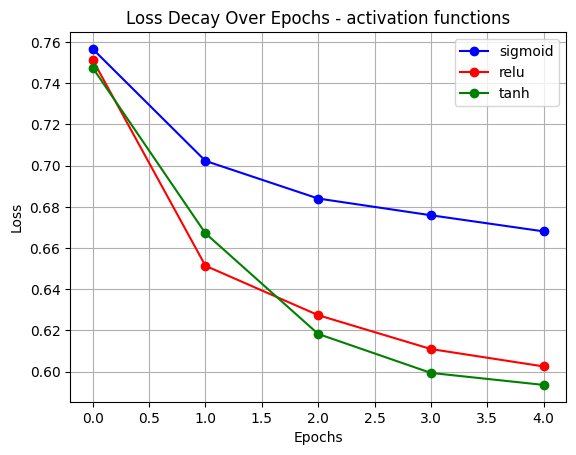

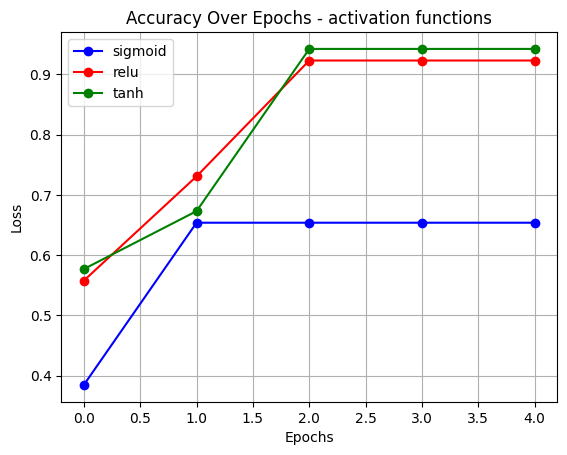

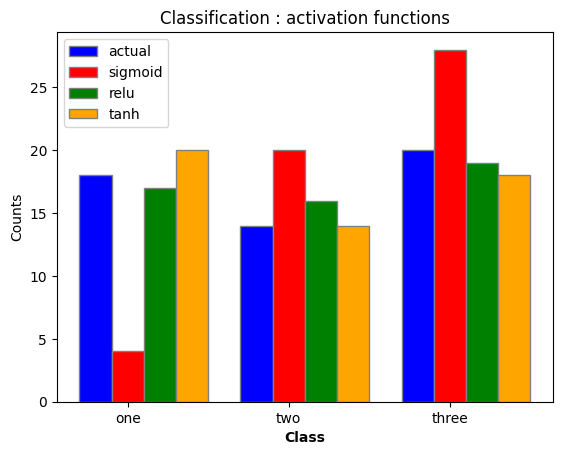

In [ ]:
multi_plot_suite(a, t1, t2, t3, n_epochs, "activation functions")

In [ ]:
'''
Output notes:
this classification problem is trivial, after a single epoch things correct out
graphs start after one epoch, so its already trained well
accuracy graph, confusion matrix converted into bar graph

'''